## Exponential learning rate

No of images in training set: 835
No of images in validation set: 104
No of images in test set: 105
No of images in feeder set: 15079
Labels: ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
Labels (feeder): ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']


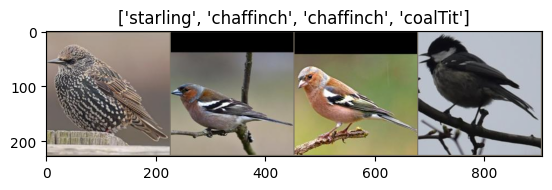

In [15]:
from torch.optim import lr_scheduler
%run setup.ipynb

In [16]:
def train_model_scheduled(model, optimizer,scheduler, num_epoch=5, train = dataloader_train, validation= dataloader_validation):
    acc_train = []
    loss_train = []
    acc_validation = []
    loss_validation = []
    lr_rate = []
    best_acc = 0.0
    best_loss = 1.0
    best_epoch = 0
    best_model_weight = copy.deepcopy(model.state_dict())

    since = time.time()
    for epoch in range(num_epoch):
        epoch_since = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print("-"*10)
        print('Learning rate: {:n}'.format(scheduler.get_last_lr()[0]))
        lr_rate.append(scheduler.get_last_lr()[0])
        #training phase
        
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train:
            inputs = inputs.to(device)
            labels = labels.to(device)

            #zero the parameter gradients 
            optimizer.zero_grad()

            #forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss_train = running_loss / dataset_size_train
        epoch_acc_train = running_corrects.double() / dataset_size_train
        acc_train.append(epoch_acc_train.item())
        loss_train.append(epoch_loss_train)
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

        #validation phase
        model.eval()
        running_loss_val = 0.0
        running_corrects_val = 0
        for inputs, labels in validation:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)
        epoch_loss_val = running_loss_val / dataset_size_val
        epoch_acc_val = running_corrects_val.double() / dataset_size_val
        acc_validation.append(epoch_acc_val.item())
        loss_validation.append(epoch_loss_val)
        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
        
        if(epoch_acc_val > best_acc):
            best_acc = epoch_acc_val
            best_loss = epoch_loss_val #not ness the best loss overall but the loss of the best model
            best_epoch = epoch+1
            best_model_weight = copy.deepcopy(model.state_dict())
        
        scheduler.step()
        
        time_epoch_val = time.time() - epoch_since           
        print('Epoch time {:.0f}m {:.0f}s'.format(time_epoch_val // 60, time_epoch_val % 60))
        print("-"*10)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best model had accuracy {:.4f}, loss {:.4f} at epoch {}".format(best_acc, best_loss, best_epoch))
    print("Validation accuracies:")
    print(acc_validation)
    print("Training accuracies:")
    print(acc_train)
    print(scheduler.state_dict())
    data = {"train_loss": loss_train, "val_loss": loss_validation, "train_acc": acc_train, "val_acc": acc_validation, "lr_rates": lr_rate}
    model.load_state_dict(best_model_weight)
    return model, data

def plot_learning_rate(lr_rates):
    num_epochs = len(lr_rates)
    plt.figure(figsize=(5,5))
    plt.plot(np.arange(1,num_epochs+1), lr_rates,'-')
    plt.xlabel('Epoch')
    plt.legend(["lr"])
    plt.ylabel('Learning rate')
    plt.title('Learning rate/Epoch')
    plt.show()

In [17]:
training_in_here = dataloader_train
validation_in_here = dataloader_validation
num_epochs = 24

In [18]:
model = load_and_prep_resnet50()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9) # <- then decay this instead

# decay lr of each parameter by 0.1 every seven'th epoch
exp_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=2, gamma=0.1)
# TODO lol is this exponential? hvis man decreaser med x*lr hver gang?


In [19]:
freezeTrained_model_exp, freezeData_exp = train_model_scheduled(model=model, optimizer=optimizer, scheduler=exp_scheduler, num_epoch=num_epochs, train=training_in_here, validation=validation_in_here )

Epoch 1/24
----------
Learning rate: 0.1
Train Loss: 1.3991 Acc: 0.6802
Val Loss: 0.2817 Acc: 0.8942
Epoch time 2m 2s
----------

Epoch 2/24
----------
Learning rate: 0.1
Train Loss: 0.5732 Acc: 0.8766
Val Loss: 0.1970 Acc: 0.9327
Epoch time 2m 10s
----------

Epoch 3/24
----------
Learning rate: 0.01
Train Loss: 0.4439 Acc: 0.9078
Val Loss: 0.1112 Acc: 0.9519
Epoch time 2m 5s
----------

Epoch 4/24
----------
Learning rate: 0.01
Train Loss: 0.1988 Acc: 0.9473
Val Loss: 0.1403 Acc: 0.9423
Epoch time 1m 52s
----------

Epoch 5/24
----------
Learning rate: 0.001
Train Loss: 0.2272 Acc: 0.9413
Val Loss: 0.0960 Acc: 0.9519
Epoch time 1m 53s
----------

Epoch 6/24
----------
Learning rate: 0.001
Train Loss: 0.1721 Acc: 0.9521
Val Loss: 0.0636 Acc: 0.9615
Epoch time 1m 49s
----------

Epoch 7/24
----------
Learning rate: 0.0001
Train Loss: 0.1851 Acc: 0.9401
Val Loss: 0.0647 Acc: 0.9615
Epoch time 1m 49s
----------

Epoch 8/24
----------
Learning rate: 0.0001
Train Loss: 0.1781 Acc: 0.9449
V

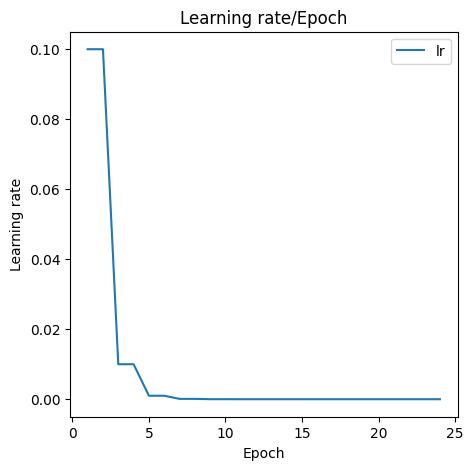

In [20]:
plot_learning_rate(freezeData_exp["lr_rates"])

In [21]:
unfreeze_layers(freezeTrained_model_exp)
model_exp, model_exp_data = train_model_scheduled(model=freezeTrained_model_exp, optimizer=optimizer, scheduler=exp_scheduler, num_epoch=num_epochs, train=training_in_here, validation=validation_in_here)

Epoch 1/24
----------
Learning rate: 1e-13
Train Loss: 0.1756 Acc: 0.9533
Val Loss: 0.2093 Acc: 0.9423
Epoch time 5m 12s
----------

Epoch 2/24
----------
Learning rate: 1e-13
Train Loss: 0.1830 Acc: 0.9509
Val Loss: 0.0667 Acc: 0.9808
Epoch time 5m 22s
----------

Epoch 3/24
----------
Learning rate: 1e-14
Train Loss: 0.1735 Acc: 0.9377
Val Loss: 0.1556 Acc: 0.9327
Epoch time 5m 24s
----------

Epoch 4/24
----------
Learning rate: 1e-14
Train Loss: 0.1215 Acc: 0.9593
Val Loss: 0.1201 Acc: 0.9327
Epoch time 5m 17s
----------

Epoch 5/24
----------
Learning rate: 1e-15
Train Loss: 0.1560 Acc: 0.9521
Val Loss: 0.0986 Acc: 0.9423
Epoch time 5m 14s
----------

Epoch 6/24
----------
Learning rate: 1e-15
Train Loss: 0.1384 Acc: 0.9545
Val Loss: 0.1260 Acc: 0.9519
Epoch time 5m 33s
----------

Epoch 7/24
----------
Learning rate: 1e-16
Train Loss: 0.1882 Acc: 0.9473
Val Loss: 0.0396 Acc: 0.9808
Epoch time 5m 38s
----------

Epoch 8/24
----------
Learning rate: 1e-16
Train Loss: 0.1593 Acc: 0.

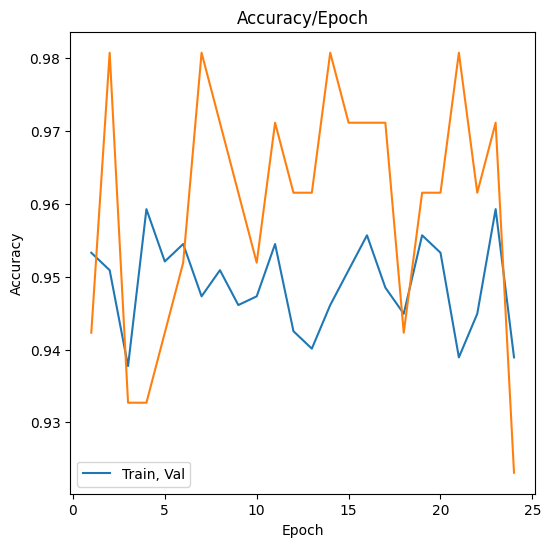

In [22]:
plot_accuracies(model_exp_data["train_acc"], model_exp_data["val_acc"], ["Train, Val"])

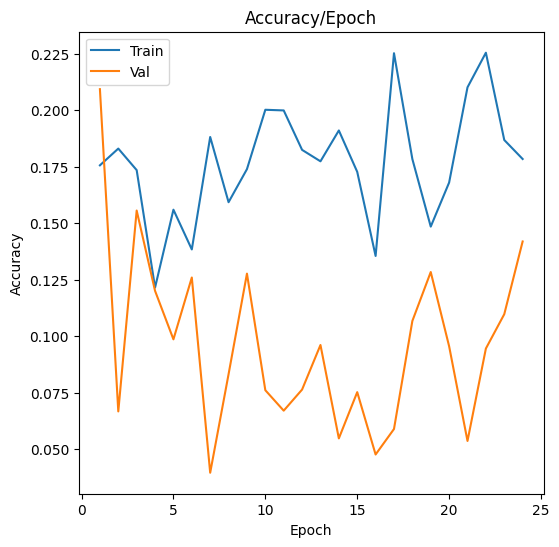

In [36]:
plot_accuracies(model_exp_data["train_loss"], model_exp_data["val_loss"], ["Train", "Val"])

[[15  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0]
 [ 0  0 15  0  0  0  0]
 [ 0  1  0 14  0  0  0]
 [ 0  0  4  0 10  0  1]
 [ 0  1  0  0  0 14  0]
 [ 0  0  0  0  0  0 15]]
Accuracy 93.33333333333333


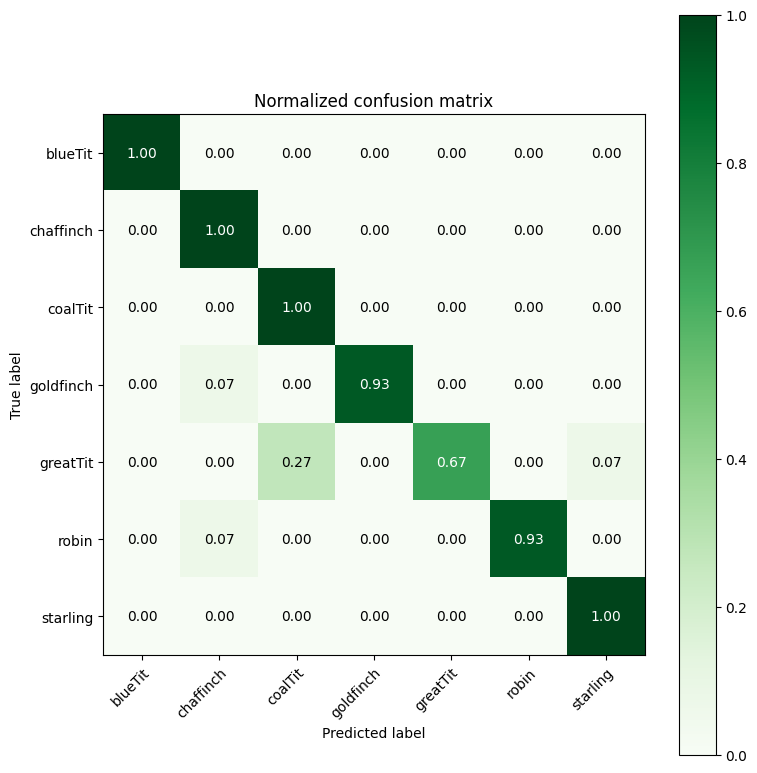

In [23]:
truel, predl = makeAll(dataloader_test, model_exp, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

In [30]:
import torch
torch.save({"model_exp": model_exp.state_dict(), "model_exp_data": model_exp_data, "freeze_data": freezeData_exp},"expModel.tar")

In [32]:
didTHisWork = torch.load("expModel.tar", weights_only=True)
loadModel = load_and_prep_resnet50()
loadModel.load_state_dict(didTHisWork["model_exp"])


c:\Users\annek\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

[[ 125   22  278  200  375  121  957]
 [  50  298  549  381  222  343 1709]
 [   3    1  922  151  151   54  564]
 [   1   25  266 1442  112   84   70]
 [  30    7  313  129  752   82  720]
 [   4   38   19   25   16  781  545]
 [  17    7  422    8   61   79 1548]]
Accuracy 38.91504741693746


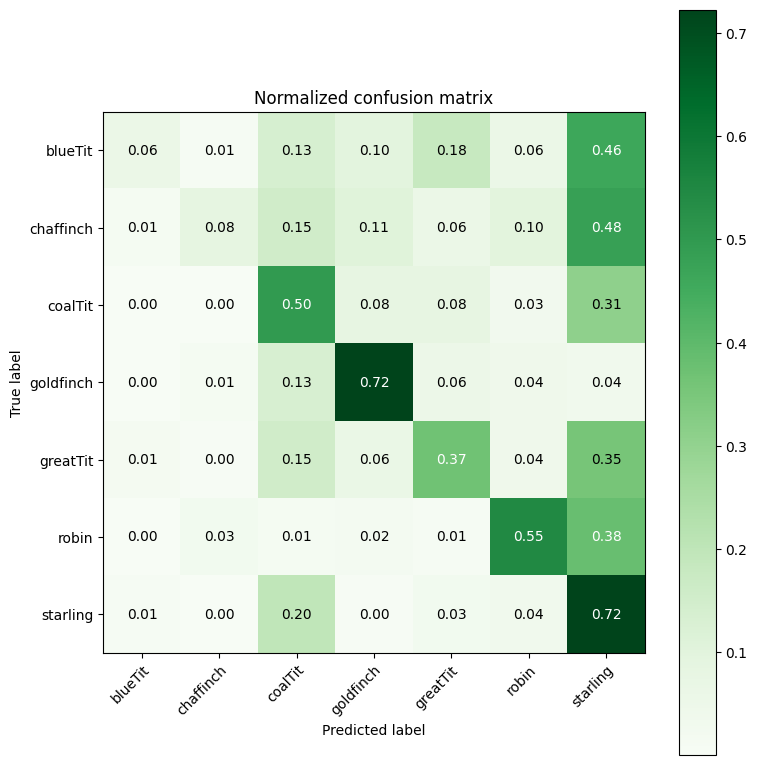

In [ ]:
loadModel.eval()
truel, predl = makeAll(dataloader_feeder, loadModel, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

In [ ]:
didTHisWork["freeze_data"]

In [ ]:
print(load_and_prep_resnet50())